# Telecom : Exam 2021

## Table of content 
* [Import](#Import)
* [Utilities](#Utilities)
* [Read](#Read)
* [Data mining and cleaning](#DMC)
    * [Overview](#Overview)
    * [Data Visualisation](#Graphs)
    * [Data Cleaning](#DataCleaning)
* [Data Modeling](#DataModeling)
    * [Preprocessing](#Prepro)
* [Testing and modeling](#TestsModels)
    * [KNN](#KNN)
    * [Decision Tree](#DT)
    * [Random Forest](#RF)
* [Improvements](#Improvements)
    * [Decision Tree hyperparameters improvement](#DTHI)
    * [Random Forest hyperparameters improvement](#RFHI)
* [Model performance according to the train set size](#ModelPerf)
* [Conclusion](#Conclusion)


## Import <a id ="Import"></a>

Ici on centralise tout les imports dont on aura besoin dans notre traitement.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Utilities <a id="Utilities"></a>

Ici on reprend la méthode fournie lors des cours pour permettre une visualisation des données.

In [2]:
def data_overview(df):
    print("####### Data overview #######")
    print("Rows - columns :" , df.shape)
    print("Number of features : ",df.shape[1]-1)
    print()
    print("Liste des colonnes : ")
    print("_____________________")
    print()
    print(df.columns)
    print()
    print("Liste des types : ")
    print("_____________________")
    print()
    print(df.info())
    print()
    print("Valeurs manquantes par colonne: ")
    print("________________________________")
    print()
    print(df.isnull().sum())
    print()
    print()
    print("Nombre total de valeurs manquantes: ")
    print("____________________________________")
    print()
    print(df.isnull().sum().values.sum())
    print()
    print("Nbre de valeurs différent es par colonne : ")
    print("__________________________________________")
    print()
    print(df.nunique())

## Read <a id="Read"></a>

Ici on charge les deux datasetss fournis, un servira à l'entrainement, l'autre à le tester.

In [3]:
telecoms_train = pd.read_csv("churn-bigml-80.csv", delimiter=",")
telecoms_test = pd.read_csv("churn-bigml-20.csv", delimiter=",")

Voici les 5 premières lignes.

Chacune d'entre elles représente un ensemble d'informations concernant un client. 
- State : l'abréaviation de l'état (USA) dans lequel le client a enregistrer son compte
- Area code : l'indicatif téléphonique du numéro de téléphone
- International plan : si le compte possède un plan tarifaire pour les communication à l'étranger
- Voice mail plan : si le plan tarifaire comprend l'utilisation d'une boîte mail liée
- Number vmail message : le nombre de message vocal envoyé via ce compte
- Total ... minutes : le nombre total de minutes passé en communication le jour(day), la nuit(night), en soirée(eve) ou à l'international(intl)
- Total ... calls : le nombre total d'appel passé durant le jour(day), la nuit(night), en soirée(eve) ou à l'international(intl)
- Total ... charge : le montant total à payer pour les communications effectuées le jour(day), la nuit(night), en soirée(eve) ou à l'international(intl)
- Customer service calls : le nombre d'appel passé au service clientèle
- Churn : la colonne représente l'état du client au sein de la clientèle, 1 il est parti, 0 il est toujours client

In [4]:
telecoms_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data mining and cleaning <a id="DMC"></a>

#### Overview <a id="Overview"></a>

Ici on regarde plus en détails ce que contient le dataset en utilisant la fonction fournie dans utilities

In [5]:
data_overview(telecoms_train)

####### Data overview #######
Rows - columns : (2666, 20)
Number of features :  19

Liste des colonnes : 
_____________________

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

Liste des types : 
_____________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   in

Ici on visualise les corrélations entre les différentes variables.

<AxesSubplot:title={'center':'Heatmap de la correlation entre les variables'}>

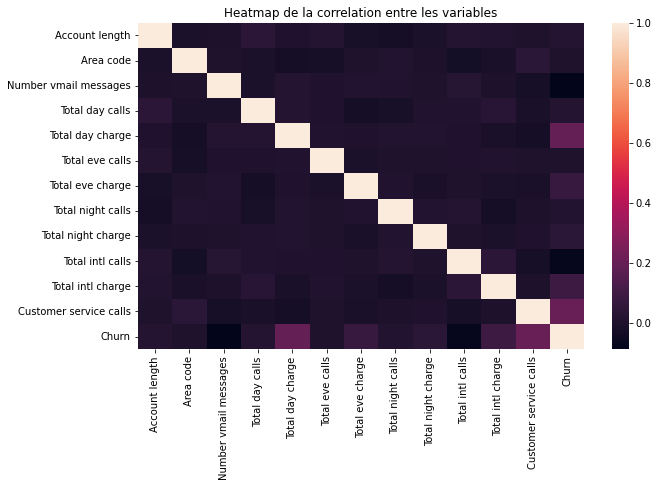

In [29]:
plt.figure(figsize=(10, 6))
plt.title("Heatmap de la correlation entre les variables")
sns.heatmap(telecoms_train.corr())

#### Data visualisation <a id="Graphs"></a>

On distingue dans un premier temps les valeurs catégorièlles des numériques

In [7]:
numerical_columns = ['Account length', 'Number vmail messages',
       'Total day calls', 'Total day charge', 
       'Total eve calls', 'Total eve charge', 
       'Total night calls', 'Total night charge',
       'Total intl calls', 'Total intl charge', 'Customer service calls',]
categorical_columns = ['State', 'Area code', 'International plan',
       'Voice mail plan']


On a les colonnes bien séparées.

On utilise un pairplot qui va associé deux à deux chaque variable numérique. En orange et en bleu sont représentées respectivement les personnes qui partent et celles qui restent.
Si on regarde attentivement on se rend compte qu'une série de graphique sort du lot. Les graphiques concernant les 'Total day charge'.

KeyboardInterrupt: 

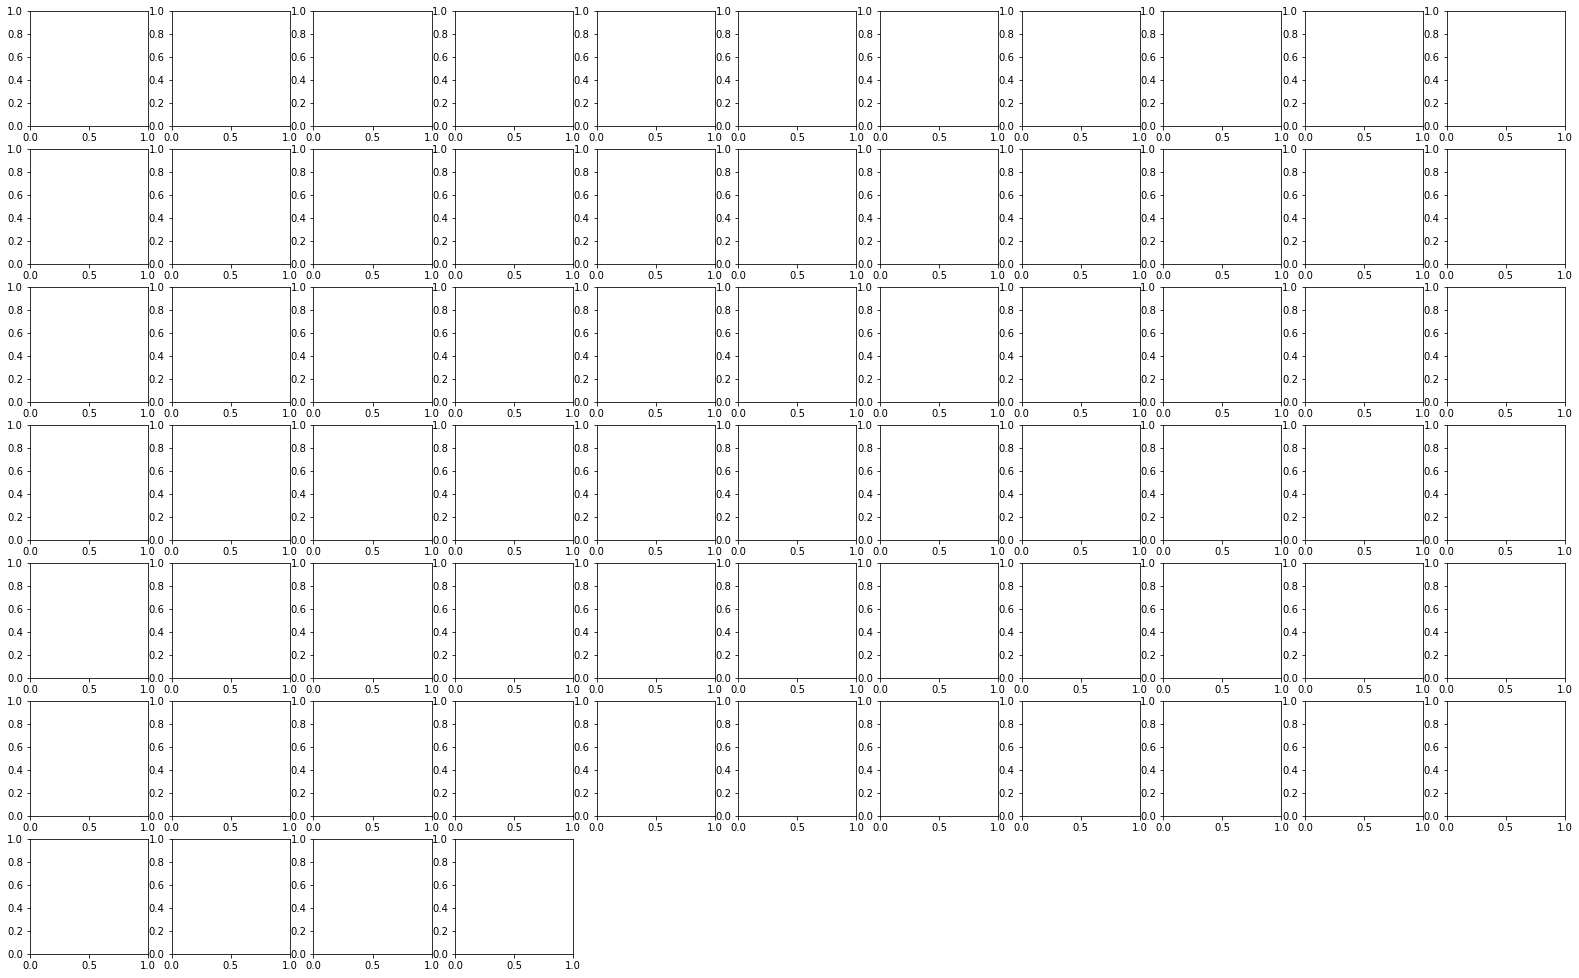

In [33]:
sns.pairplot(telecoms_train[numerical_columns + ['Churn']], hue = 'Churn')

Nous allons donc isoler la donnée 'Total day charge' pour la mettre en relation avec les données catégorielles, toujours en tenant compte de la target.

Text(0.5, 1.0, 'Nombre de téléphone appelés par état')

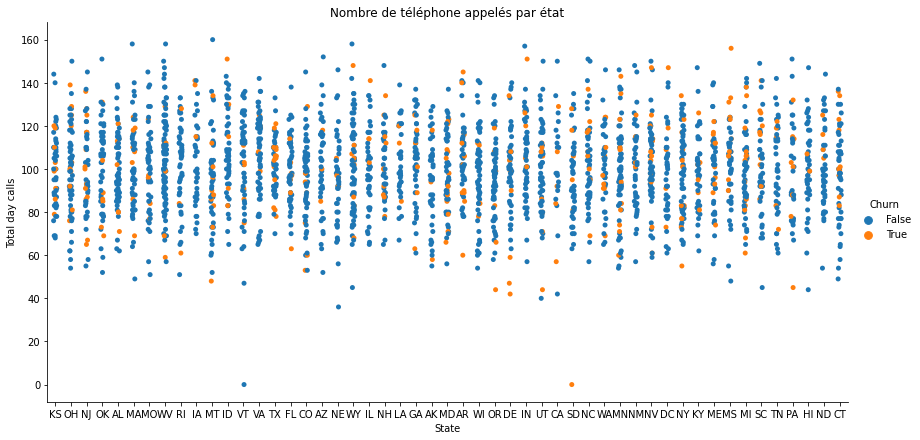

In [34]:
sns.catplot(x='State', y='Total day calls',data=telecoms_train, hue='Churn', height=6, aspect=2)
plt.title("Nombre de coup de téléphone par jour par personne réparti par état")

Ici pas de choses notables qui ressort.

Text(0.5, 1.0, 'Nombre de coup de téléphone par jour par personne réparti par Area Code')

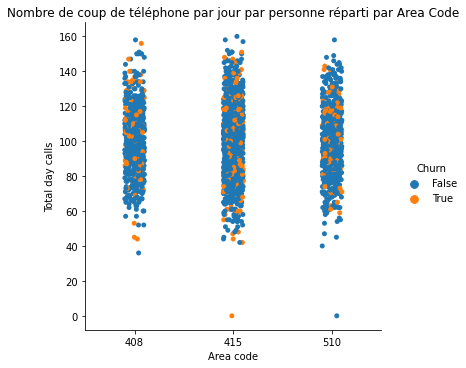

In [35]:
sns.catplot(x='Area code', y='Total day calls',data=telecoms_train, hue='Churn')
plt.title("Nombre de coup de téléphone par jour par personne réparti par Area Code")


Ici non plus

Text(0.5, 1.0, 'Nombre de coup de téléphone par jour par personne réparti par International Plan')

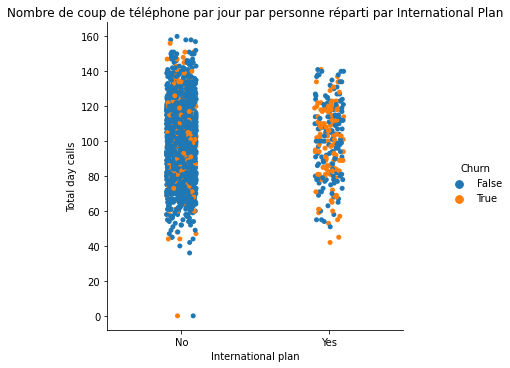

In [36]:
sns.catplot(x='International plan', y='Total day calls',data=telecoms_train, hue='Churn')
plt.title("Nombre de coup de téléphone par jour par personne réparti par International Plan")

A partir d'ici on voit clairement une forte concentration des personnes sur le départ lorsqu'elle possède un plan international, quelque soit leur durée journalière d'appel.

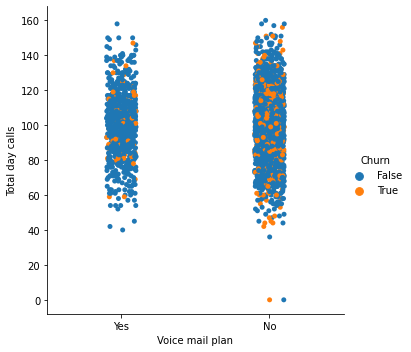

In [12]:
sns.catplot(x='Voice mail plan', y='Total day calls',data=telecoms_train, hue='Churn')

Ici aussi, bien que de manière moins marquée.

Une autre valeur numérique avec des tendances fort marquée est le 'Customer service calls'.

Text(0.5, 1.0, 'Nombre de coup de téléphone au service client par personne réparti par état')

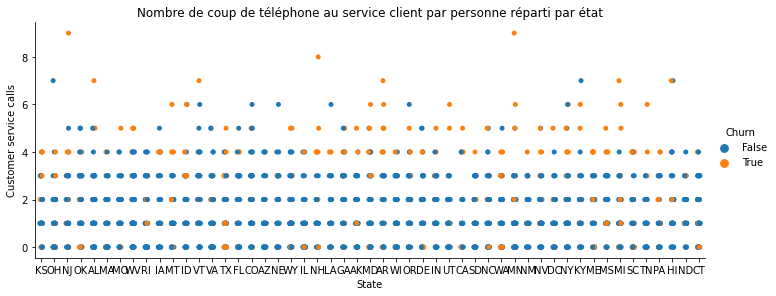

In [39]:
sns.catplot(x='State', y='Customer service calls',data=telecoms_train, hue='Churn', height=4, aspect=2.5)
plt.title("Nombre de coup de téléphone au service client par personne réparti par état")

On voit que quelque soit l'état, au plus un client fait d'appel au service client au plus il fait partie des personnes sur le départ.

Text(0.5, 1.0, 'Nombre de coup de téléphone au service client par personne réparti par Area Code')

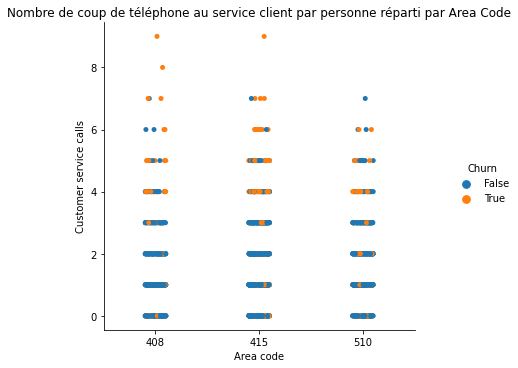

In [40]:
sns.catplot(x='Area code', y='Customer service calls',data=telecoms_train, hue='Churn')
plt.title("Nombre de coup de téléphone au service client par personne réparti par Area Code")

De même ici en fonction de l''Area code'.

Text(0.5, 1.0, 'Nombre de coup de téléphone au service client par personne réparti par International Plan')

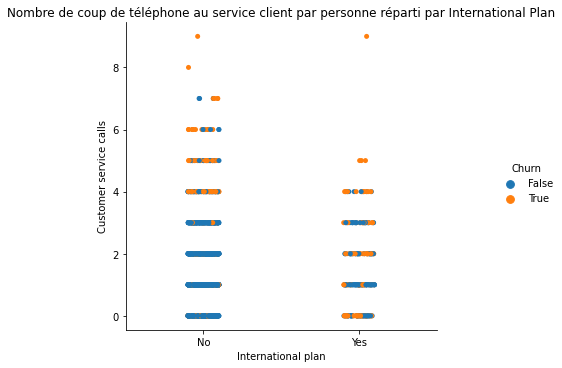

In [42]:
sns.catplot(x='International plan', y='Customer service calls',data=telecoms_train, hue='Churn')
plt.title("Nombre de coup de téléphone au service client par personne réparti par International Plan")

Ici petite particularité, tout en ayant une même tendance que précédement. Les gens possédant un 'International plan' semblent bien moins enclin à la patience que ceux n'en possèdant pas.

Text(0.5, 1.0, 'Nombre de coup de téléphone au service client par personne réparti par Voice Mail Plan')

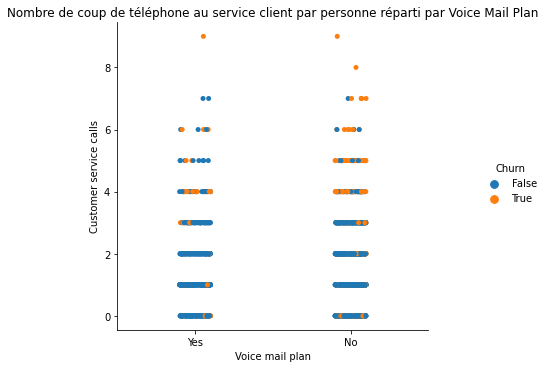

In [41]:
sns.catplot(x='Voice mail plan', y='Customer service calls',data=telecoms_train, hue='Churn')
plt.title("Nombre de coup de téléphone au service client par personne réparti par Voice Mail Plan")

Et ici on reste sur la même idée. Au plus le client appel le service client, au plus il est succeptible de nous quitter.

En conclusion, on peut dire qu'un client qui appel un nombre de fois élevé le service clientèle est d'autant plus succeptible de partir. Attention cette tendance est d'autant plus rapide si le client possède un 'International plan'.

#### Data Cleaning <a id="DataCleaning"></a>

On retire les colonnes des totaux des minutes car on a vu sur la Heatmap qu'ils ont une correlation de 1 avec les charges. C'est à dire qu'on peut déterminer l'un en fonction de l'autre sans erreur. Avoir les 2 informations est donc superflu.

In [17]:
non_essentials_data = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']
telecoms_train = telecoms_train.drop(non_essentials_data, axis=1)
telecoms_test = telecoms_test.drop(non_essentials_data, axis=1)

## Data modeling <a id="DataModeling"></a>

### Preprocessing <a id="Prepro"></a>

On répartit les données en un dataframe contenant les features et une série contenant notre target.

In [18]:
X_train = telecoms_train.drop(["Churn"], axis=1)
y_train = telecoms_train["Churn"]

On prépare la standardisaton des données suivant leur nature à travers le pipeline qui sera utilisé par le GridSeachCV.

In [19]:
numerical_features = numerical_columns
categorical_features = categorical_columns

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),(categorical_pipeline, categorical_features))


On prépare un `SelectKBest` pour pouvoir l'utiliser dans les pipelines pour le Decision Tree et le Random Forest

In [20]:
selector = SelectKBest()

## Testing and modeling <a id="TestsModels"></a>

On réalise ensuite une série de test dans le cas d'une classification KNN en faisant varié une série de paramètre et en ne gardant que les meilleurs.<br>
On fait de même avec la classification Decision Tree et Random Forest.<br>
Une fois fait on garde ce meilleur résultat dans une variable.<br>

In [21]:
clf_knn = KNeighborsClassifier()
param_grid_knn = {
    # 'selectkbest__k': range(0, X_train.shape[1]),
    # 'selectkbest__score_func': [chi2],
    'kneighborsclassifier__n_neighbors': range(1, 10),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__metric': ['minkowski', 'euclidean', 'manhattan'],
}
model_knn = make_pipeline(preprocessor, clf_knn)
grid_search_knn = GridSearchCV(model_knn, param_grid_knn, cv=5, scoring='recall', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)
best_model_knn = grid_search_knn.best_estimator_


{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
0.33772893772893775


In [22]:
clf_dt = DecisionTreeClassifier()
param_grid_dt = {
    'selectkbest__k': range(1, 10),
    'selectkbest__score_func': [chi2],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': range(1, 10),
    'decisiontreeclassifier__min_samples_split': range(2, 5),
    'decisiontreeclassifier__min_samples_leaf': range(1, 5),
    'decisiontreeclassifier__max_features': ['auto'],
    'decisiontreeclassifier__random_state': [42],
}
preprocessor_dt = make_column_transformer(
    (categorical_pipeline, categorical_features), remainder='passthrough')
model_dt = make_pipeline(preprocessor_dt, selector, clf_dt)
grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='recall', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)
best_model_dt = grid_search_dt.best_estimator_


{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__random_state': 42, 'decisiontreeclassifier__splitter': 'best', 'selectkbest__k': 9, 'selectkbest__score_func': <function chi2 at 0x000001C7C34088B0>}
0.615984015984016


In [23]:
clf_rf = RandomForestClassifier()
param_grid_rf = {
    'selectkbest__k': range(1, 10),
    'selectkbest__score_func': [chi2],
    'randomforestclassifier__n_estimators': range(1, 10),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': range(1, 10),
    'randomforestclassifier__min_samples_split': range(2, 5),
    'randomforestclassifier__min_samples_leaf': range(1, 5),
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__random_state': [42],
}
preprocessor_rf = make_column_transformer(
    (categorical_pipeline, categorical_features), remainder='passthrough')
model_rf = make_pipeline(preprocessor_rf, selector, clf_rf)
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)
best_model_rf = grid_search_rf.best_estimator_


{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 8, 'randomforestclassifier__random_state': 42, 'selectkbest__k': 9, 'selectkbest__score_func': <function chi2 at 0x000001C7C34088B0>}
0.6390609390609391


Une fois nos classifications optimisées, il est temps de les appliquées à nos modèles de test.<br>
Pour ce faire on créer un dataset avec nos features de test, et une série avec la target toujours de notre test.<br>

In [24]:
X_test = telecoms_test.drop(["Churn"], axis=1)
y_test = telecoms_test["Churn"]
y_test = y_test

On calcule les prédictions.

In [25]:
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_dt = best_model_dt.predict(X_test)
y_pred_rf = best_model_rf.predict(X_test)

## Model performance according to the test set size <a id="ModelPerf"></a>

On vérifie sur base de notre target de test, les prédictions obtenues à travers le classification_report, qui permet l'affichage de divers données.

Ce qui nous intérresse surtout ici c'est la colonne `precision`, mais surtout la colonne `recall` qui nous donne une précision suplémentaire et bien plus précise sur la performance réalisé par notre modèle de classification.

En effet, on veut pouvoir cibler l'ensemble des personnes qui comptent vraiment partir, pour cela la valeur du `recall` est importante. Cependant, il faut aussi éviter de considérer trop de gens sur le point de partir alors qu'il ne le sont pas, pour cela la valeur `precision` est importante.

Il faut trouver le juste milieu entre les deux valeur et principalement pour la ligne `True` car du point de vue de l'opérateur, il est plus intéressant de déterminer le plus précisemment possible les clients qui vont partir.

On commence avec le rapport pour le KNN.

In [26]:
print("KNN:")
print(classification_report(y_test, y_pred_knn))

KNN:
              precision    recall  f1-score   support

       False       0.89      0.94      0.92       572
        True       0.48      0.33      0.39        95

    accuracy                           0.85       667
   macro avg       0.69      0.63      0.65       667
weighted avg       0.83      0.85      0.84       667



Pour la ligne `True`, nous avons une précision de 0.48, ce qui n'est pas énorme et un recall de 0.33, ce qui est assez bas.

En revanche, le modèle est assez précis pour la ligne `False` mais elle est moins intéressante.

In [27]:
print("DT:")
print(classification_report(y_test, y_pred_dt))

DT:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94       572
        True       0.68      0.57      0.62        95

    accuracy                           0.90       667
   macro avg       0.81      0.76      0.78       667
weighted avg       0.90      0.90      0.90       667



Toujours pour la ligne `True`, les résulats sont plus satisfaisants. Ils sont tous les 2 au dessus de 50%, cependant il reste une grosse marge d'améloriation.

In [28]:
print("RF:")
print(classification_report(y_test, y_pred_rf))

RF:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       572
        True       0.82      0.72      0.76        95

    accuracy                           0.94       667
   macro avg       0.89      0.84      0.86       667
weighted avg       0.93      0.94      0.94       667



Avec un Random Forest, les résultats sont bien meilleurs. La précision attend les 82% et le recall 72%. Les scores commencent à être acceptable. Par contre, pour la ligne `False`, les résulats sont excellent avec une précision à 95% et un recall à 0.97%. 

## Conclusion <a id="Conclusion"></a>

Le meilleur modèle à utiliser d'après nos tests est le random forest avec comme paramètre:
- Critérion: entropy
- max_depth: 9
- max_features: auto
- min_samples_leaf: 1
- min_samples_split: 3
- n_estimators: 8

et avec 9 features sélectionnées par le SelectKBest

Le KNN est à éviter tandis que le Decision Tree pourrait être acceptable sans plus.

Le modèle n'utilise pas de SelectKBest pour le KNN car les variables quantitavives ont été standardisées et donc possédaient des valeurs négatives. Nous n'avons pas trouvé de solution pour palier à ce problème, peut-être aurait-il fallu utiliser autre chose que `chi2` ou bien gérer autrement la sélection des features.

Pour les modèles Decision Tree et Random Forest, les variables numériques n'ont pas été standardisées car les algorithmes n'en ont pas forcément besoin pour être efficace.